### Notebook 3 of Capstone Project: Modelling Using SKTIME/SARIMA!

Summary of this notebook:

In this notebook, I use the sktime and pmdarima libraries to model the three different catalogs (and datasets) I've put together for the project: the TexNet/USGS catalog, the Fasola/TexNet catalog, and then the USGS/Fasola/TexNet catalog (I called that one Mega). Each of these catalogs were modelled to the time frame appropriate for that dataset, and I experimented with different targets (Daily Avg Magnitude, Daily Sum of Magnitudes, and Daily Count of events), and different exogenous features, along with the y target itself. Please note that this notebook is a summary of the best models for each catalog, and if you would like to see more in-depth modelling, please see the corresponding notebook in the 'old_code' folder. In this notebook I just wanted to show a little bit of the experimentation I did and show that I found the best model to be with the Mega dataset, the best target to be the Daily Average Magnitude, and the best exogenous feature for prediction was the average volume of water per ft. I used the AIC and rmse scores to compare my models. Enjoy!

Import the needed libraries here:

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import EnsembleForecaster

import pmdarima as pmd
from pmdarima.utils import tsdisplay

#### Part 1: Modelling for TexNet/USGS Catalogs

In [32]:
data = pd.read_csv('oil_and_gas_data/data_for_modelling/data_ready_for_modelling.csv', index_col=0)
data.head()

,Daily_Avg,Daily_Sum,Daily_Count,Dly_Cnt_Diff,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft
2016-01-01,0.0,0.0,0,NaN,33.0,37.13,36.61,9.0,5.080098e+06,1088.829502
2016-01-02,0.0,0.0,0,0.0,33.0,37.13,36.61,11.0,5.892634e+06,1044.749861
2016-01-03,0.0,0.0,0,0.0,33.0,37.13,36.61,9.0,4.539134e+06,1125.551135
2016-01-04,0.0,0.0,0,0.0,33.0,36.81,36.28,26.0,1.135010e+07,848.112281
2016-01-05,0.0,0.0,0,0.0,33.0,35.97,35.56,26.0,1.135010e+07,848.112281


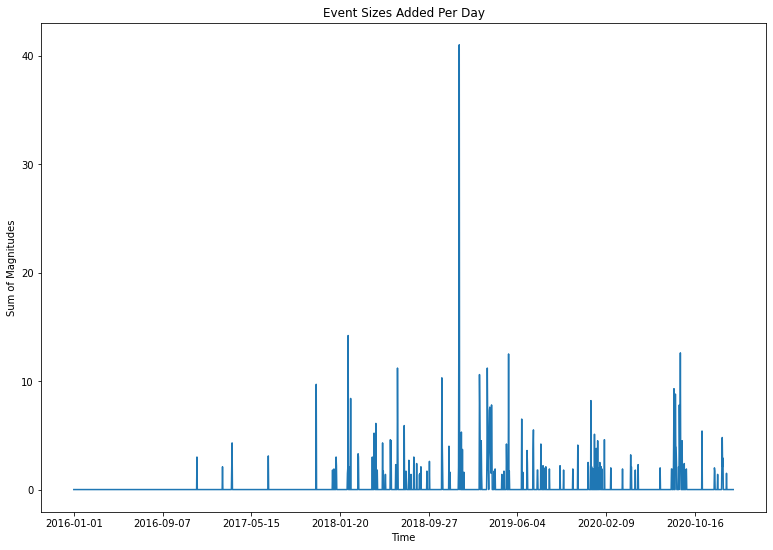

In [33]:
data['Daily_Sum'].plot(figsize=(13,9))
plt.xlabel('Time')
plt.ylabel('Sum of Magnitudes')
plt.title('Event Sizes Added Per Day');

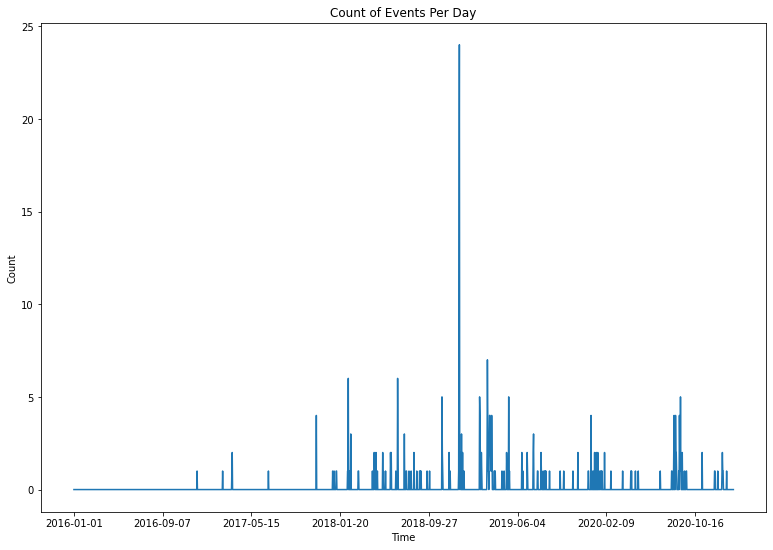

In [34]:
data['Daily_Count'].plot(figsize=(13,9))
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Count of Events Per Day');

I am going to use data from 1/1/2017 to 9/30/2019 to forecast seismicity that occurred in 3Q 2019 - 1Q 2020. In trying to model the daily data, I've learned that the models run REALLY REALLY slow, even on google co-lab, so I have to resample this dataframe to weekly. So I'll do that first and take a look at similar plots as above.

In [35]:
data.index = pd.to_datetime(data.index)

In [36]:
weekly_data = data.resample('W').mean()
weekly_data.head(3)

,Daily_Avg,Daily_Sum,Daily_Count,Dly_Cnt_Diff,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft
2016-01-03,0.0,0.0,0.0,0.0,33.0,37.130000,36.610000,9.666667,5.170622e+06,1086.376832
2016-01-10,0.0,0.0,0.0,0.0,33.0,34.234286,33.472857,26.571429,1.235401e+07,825.894278
2016-01-17,0.0,0.0,0.0,0.0,33.0,30.261429,29.014286,24.285714,1.620145e+07,1014.034459


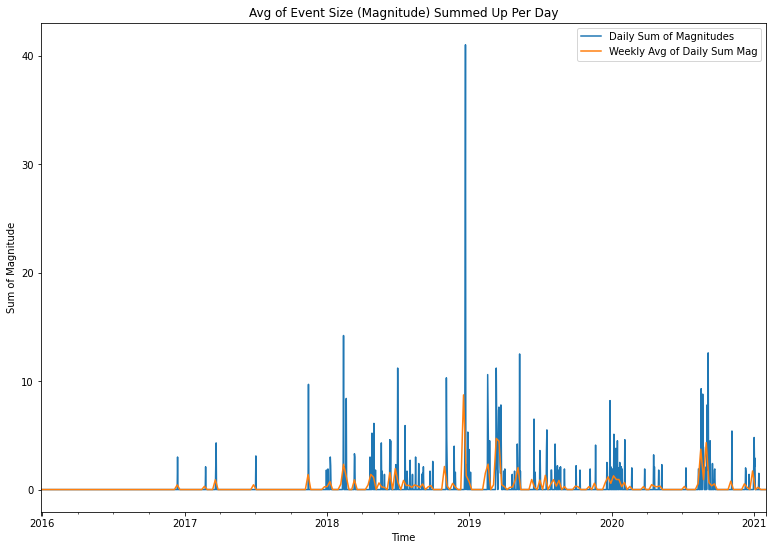

In [37]:
data['Daily_Sum'].plot(figsize=(13,9), label='Daily Sum of Magnitudes')
weekly_data['Daily_Sum'].plot(figsize=(13,9), label='Weekly Avg of Daily Sum Mag')
plt.xlabel('Time')
plt.ylabel('Sum of Magnitude')
plt.title('Avg of Event Size (Magnitude) Summed Up Per Day')
plt.legend();

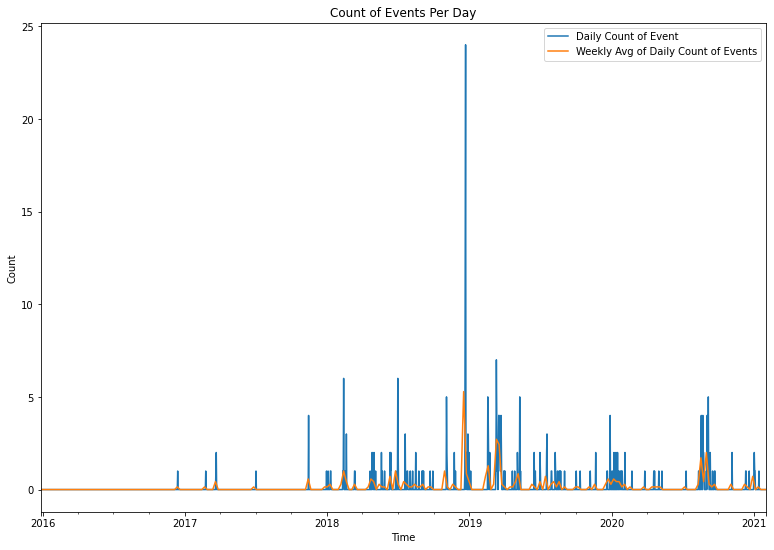

In [38]:
data['Daily_Count'].plot(figsize=(13,9), label='Daily Count of Event')
weekly_data['Daily_Count'].plot(figsize=(13,9), label='Weekly Avg of Daily Count of Events')
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Count of Events Per Day')
plt.legend();

Next steps are to split into train and test sets, then set up a baseline model.

In [39]:
train_subset =  weekly_data.loc['2017':'9-30-2019',]
test_subset = weekly_data.loc['10-1-2019':'3-31-2020',]

In [40]:
train_subset.tail()

,Daily_Avg,Daily_Sum,Daily_Count,Dly_Cnt_Diff,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft
2019-09-01,0.000000,0.000000,0.000000,0.0,29.285714,55.167143,60.172857,15.285714,1.328686e+07,2281.137619
2019-09-08,0.271429,0.271429,0.142857,0.0,30.000000,55.840000,60.528571,16.285714,1.216854e+07,2229.285065
2019-09-15,0.000000,0.000000,0.000000,0.0,30.000000,55.760000,62.312857,15.000000,7.904135e+06,1946.664092
2019-09-22,0.000000,0.000000,0.000000,0.0,29.428571,58.928571,65.462857,24.285714,2.016906e+07,2928.348256
2019-09-29,0.000000,0.000000,0.000000,0.0,27.142857,56.625714,62.960000,33.000000,3.260728e+07,3404.418694


In [41]:
test_subset.tail()

,Daily_Avg,Daily_Sum,Daily_Count,Dly_Cnt_Diff,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft
2020-03-01,0.000000,0.000000,0.000000,0.0,33.000000,47.352857,53.297143,17.142857,1.725344e+07,2671.754794
2020-03-08,0.000000,0.000000,0.000000,0.0,32.714286,44.307143,49.244286,28.000000,2.196417e+07,2541.374936
2020-03-15,0.000000,0.000000,0.000000,0.0,32.000000,32.195714,33.302857,30.571429,2.360722e+07,2545.060663
2020-03-22,0.000000,0.000000,0.000000,0.0,32.285714,22.847143,25.624286,32.000000,2.262417e+07,2586.057358
2020-03-29,0.271429,0.271429,0.142857,0.0,32.142857,18.307143,23.512857,33.000000,1.900354e+07,2374.692438


In [42]:
y_train = train_subset[['Daily_Count']]
y_test = test_subset[['Daily_Count']]

In [43]:
y_train = y_train.astype('float64')
y_test = y_test.astype('float64')

In [44]:
y_train.tail()

,Daily_Count
2019-09-01,0.000000
2019-09-08,0.142857
2019-09-15,0.000000
2019-09-22,0.000000
2019-09-29,0.000000


My first baseline model will be a Naive Forecast model, which uses the last value of the train set to predict the future values (test set). What am I trying to predict? I'll start by predicting Daily Count of events.

In [45]:
#start with the naive (last) model
y_train.index = y_train.index.to_period('W')
y_test.index = y_test.index.to_period('W')

In [46]:
y_train = y_train['Daily_Count']
y_test = y_test['Daily_Count']

In [47]:
#here is the last value/naive model
naive_last = NaiveForecaster(strategy= 'last')
naive_last.fit(y_train)

NaiveForecaster()

In [48]:
y_last_preds = naive_last.predict(list(range(1,len(y_test)+1)))

In [49]:
#get the rmse for the last/naive model
np.round(mse(y_test, y_last_preds, squared=False), decimals=2)

0.24

The interpretation of these metrics is that the naive (last) model has an rmse error of +/- 0.24 on the daily count of events (range in test set was 0 - 0.5 events per day).

Let's try another baseline where we use a simple average of the Daily Count of events in the training set to predict the Daily Count of events in the test set.

In [50]:
#here is the simple mean model
naive_mean = NaiveForecaster(strategy= 'mean')
naive_mean.fit(y_train)

NaiveForecaster(strategy='mean')

In [51]:
y_mean_preds = naive_mean.predict(list(range(1,len(y_test)+1)))

In [52]:
#get the rmse for the mean model
np.round(mse(y_test, y_mean_preds, squared=False), decimals=2)

0.19

This model did a little bit better than the last, a lower rmse error of 0.19.

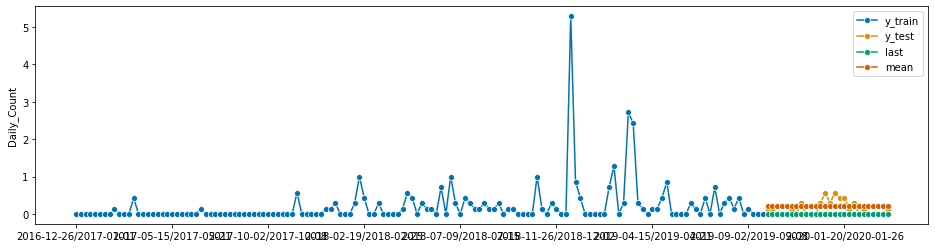

In [53]:
plot_series(y_train, y_test, y_last_preds, y_mean_preds,
            labels=['y_train', 'y_test', 'last', 'mean']);

After experimenting with each of the exogenous features in my dataset, this next model was the best in terms of rmse (which was the same as the null model). 

In [54]:
X = train_subset[['avg_volh2o_per_ft']]
sarimax_vol_ft = pmd.auto_arima(y_train, X=X, m=52, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=269.128, Time=4.77 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=313.765, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=297.083, Time=1.04 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=272.930, Time=1.17 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=311.766, Time=0.11 sec
 ARIMA(2,1,2)(0,0,1)[52] intercept   : AIC=267.014, Time=4.13 sec
 ARIMA(2,1,2)(0,0,0)[52] intercept   : AIC=265.180, Time=0.27 sec
 ARIMA(2,1,2)(1,0,0)[52] intercept   : AIC=267.938, Time=4.47 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=261.249, Time=0.15 sec
 ARIMA(1,1,2)(1,0,0)[52] intercept   : AIC=263.724, Time=1.29 sec
 ARIMA(1,1,2)(0,0,1)[52] intercept   : AIC=263.249, Time=1.22 sec
 ARIMA(1,1,2)(1,0,1)[52] intercept   : AIC=265.249, Time=1.36 sec
 ARIMA(0,1,2)(0,0,0)[52] intercept   : AIC=254.930, Time=0.09 sec
 ARIMA(0,1,2)(1,0,0)[52] intercept   : AIC=257.287, Time=2.24 sec
 ARIMA(0,1,2)(0,0,1)[52] intercep

In [55]:
sarimax_vol_ft.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -120.399
Date:                Wed, 03 Mar 2021   AIC                            250.798
Time:                        13:36:17   BIC                            265.612
Sample:                    01-01-2017   HQIC                           256.818
                         - 09-29-2019                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
avg_volh2o_per_ft -8.725e-05      0.000     -0.197      0.844      -0.001       0.001
ma.L1                -0.6969      0.068    -10.245      0.000      -0.830      -0.564
ma.L2                -0.2260      0.177     -1.274      0.203      -0.574       0.122
ma.L3                -0.0349      0.134     -0.259      0.795      -0.298       0.229
sigma2                0.3596      0.020     17.778      0.000       0.320       0.399
===================================================================================
Ljung-Box (L1) (Q):                   1.20   Jarque-Bera (JB):             16366.42
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):              68.70   Skew:                             6.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        53.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
sarimax_vol_ft_preds = sarimax_vol_ft.predict(y_test.shape[0], test_subset[['avg_volh2o_per_ft']])
np.round(mse(y_test, sarimax_vol_ft_preds, squared=False), decimals=2)

0.21

I'm now going to try using Daily Sum as a target and show the best results for that target.

In [57]:
#Going to to the same baseline models using sktime
#start with the naive (last) model
#sktime likes the format of things just so
y_train = train_subset['Daily_Sum']
y_test = test_subset['Daily_Sum']
y_train.index = y_train.index.to_period('W')
y_test.index = y_test.index.to_period('W')

In [58]:
#here is the last value/naive model
naive_last = NaiveForecaster(strategy= 'last')
naive_last.fit(y_train)

NaiveForecaster()

In [59]:
y_last_preds = naive_last.predict(list(range(1,len(y_test)+1)))
#get the rmse for the last/naive model
np.round(mse(y_test, y_last_preds, squared=False), decimals=2)

0.51

In [60]:
#here is the simple mean model
naive_mean = NaiveForecaster(strategy= 'mean')
naive_mean.fit(y_train)
y_mean_preds = naive_mean.predict(list(range(1,len(y_test)+1)))
#get the rmse for the mean model
np.round(mse(y_test, y_mean_preds, squared=False), decimals=2)

0.4

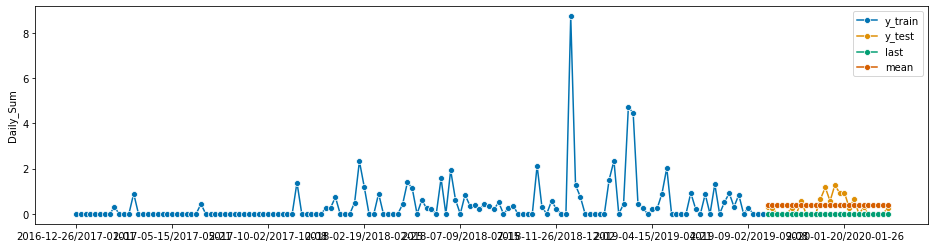

In [61]:
plot_series(y_train, y_test, y_last_preds, y_mean_preds,
            labels=['y_train', 'y_test', 'last', 'mean']);

In [62]:
X = train_subset[['avg_volh2o_per_ft']]
sarimax_vol_ft = pmd.auto_arima(y_train, X=X, m=52, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=417.342, Time=4.64 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=478.944, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=461.527, Time=2.14 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=436.611, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=476.945, Time=0.07 sec
 ARIMA(2,1,2)(0,0,1)[52] intercept   : AIC=inf, Time=4.00 sec
 ARIMA(2,1,2)(1,0,0)[52] intercept   : AIC=423.776, Time=4.60 sec
 ARIMA(2,1,2)(2,0,1)[52] intercept   : AIC=inf, Time=22.59 sec
 ARIMA(2,1,2)(1,0,2)[52] intercept   : AIC=inf, Time=19.57 sec
 ARIMA(2,1,2)(0,0,0)[52] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,1,2)(0,0,2)[52] intercept   : AIC=inf, Time=16.21 sec
 ARIMA(2,1,2)(2,0,0)[52] intercept   : AIC=inf, Time=20.30 sec
 ARIMA(2,1,2)(2,0,2)[52] intercept   : AIC=419.867, Time=20.27 sec
 ARIMA(1,1,2)(1,0,1)[52] intercept   : AIC=427.149, Time=2.88 sec
 ARIMA(2,1,1)(1,0,1)[52] intercept   : AIC=418.610, 

In [63]:
sarimax_vol_ft.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -199.746
Date:                Wed, 03 Mar 2021   AIC                            409.491
Time:                        13:38:59   BIC                            424.305
Sample:                    01-01-2017   HQIC                           415.511
                         - 09-29-2019                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
avg_volh2o_per_ft    -0.0003      0.000     -0.510      0.610      -0.001       0.001
ar.L1                 0.1323      0.086      1.532      0.125      -0.037       0.302
ar.L2                -0.1066      0.133     -0.800      0.424      -0.368       0.155
ma.L1                -0.9407      0.050    -18.808      0.000      -1.039      -0.843
sigma2                0.9383      0.047     19.980      0.000       0.846       1.030
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8606.58
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              37.73   Skew:                             5.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [64]:
sarimax_vol_ft_preds = sarimax_vol_ft.predict(y_test.shape[0], test_subset[['avg_volh2o_per_ft']])
np.round(mse(y_test, sarimax_vol_ft_preds, squared=False), decimals=2)

0.38

In summary of modelling the USGS/TexNet catalogs, I found that the best exogenous features for each target were the avgerage volume of water injected per foot of lateral. In both targets, using that feature either did as well as the null model or beat it slightly. 

#### Part 2: Modelling the Fasola catalog/dataset

In [65]:
fasola = pd.read_csv('oil_and_gas_data/data_for_modelling/fasola_data_ready_for_modelling.csv', index_col=0)
fasola.head(2)

,Daily_Avg,Daily_Sum,Daily_Count,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft,APIs
2016-01-01,0.0,0.0,0,33.0,37.13,36.61,9.0,5.080098e+06,1088.829502,"[42255346090000, 42255346080000, 4225534610000..."
2016-01-02,0.0,0.0,0,33.0,37.13,36.61,11.0,5.892634e+06,1044.749861,"[42255346090000, 42255346080000, 4225534610000..."


In [66]:
#I think I'm going to use a similar time range as the previous data, so use 1/1/2017-9/30/2019
#to forecast 3Q 2019-1Q2020.
#first I need to resample to weekly
fasola.index = pd.to_datetime(fasola.index)
weekly_fasola = fasola.resample('W').mean()
weekly_fasola.head(3)

,Daily_Avg,Daily_Sum,Daily_Count,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft
2016-01-03,0.000000,0.000000,0.000000,33.0,37.130000,36.610000,9.666667,5.170622e+06,1086.376832
2016-01-10,0.000000,0.000000,0.000000,33.0,34.234286,33.472857,26.571429,1.235401e+07,825.894278
2016-01-17,0.136829,0.136829,0.142857,33.0,30.261429,29.014286,24.285714,1.620145e+07,1014.034459


In [67]:
train_subset =  weekly_fasola.loc['2017':'7-30-2019',]
test_subset = weekly_fasola.loc['8-1-2019':'1-31-2020',]

In [68]:
train_subset

,Daily_Avg,Daily_Sum,Daily_Count,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft
2017-01-01,0.472484,1.427770,1.571429,23.285714,53.412857,54.665714,10.000000,7.635978e+06,1799.664814
2017-01-08,1.046323,8.728730,10.000000,23.142857,53.582857,55.324286,8.714286,7.436396e+06,1696.778656
2017-01-15,0.205967,1.042610,1.142857,21.571429,52.150000,54.117143,9.857143,1.055493e+07,1408.944624
2017-01-22,0.333800,0.419590,0.571429,23.571429,52.044286,54.435714,11.285714,1.102468e+07,1433.821886
2017-01-29,0.188821,0.188821,0.142857,25.000000,52.867143,54.875714,11.142857,1.092944e+07,1651.222458
...,...,...,...,...,...,...,...,...,...
2019-06-30,0.000000,0.000000,0.000000,29.000000,58.330000,66.798571,23.000000,1.916942e+07,2989.628915
2019-07-07,0.614286,0.871429,0.428571,32.000000,57.172857,63.951429,27.714286,2.362327e+07,2920.725218
2019-07-14,0.000000,0.000000,0.000000,32.000000,59.300000,66.170000,31.428571,2.418475e+07,2553.621745
2019-07-21,0.526190,1.314286,0.714286,31.714286,56.368571,62.888571,28.857143,2.074934e+07,2777.489475


In [69]:
test_subset.tail()

,Daily_Avg,Daily_Sum,Daily_Count,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft
2019-12-29,0.292857,1.171429,0.571429,30.000000,61.407143,68.857143,15.571429,1.059669e+07,2567.258945
2020-01-05,0.571429,0.571429,0.285714,30.000000,62.015714,68.304286,9.571429,6.847442e+06,1879.537642
2020-01-12,0.635714,1.271429,0.571429,30.571429,60.320000,67.598571,11.142857,9.032152e+06,1697.098045
2020-01-19,0.607143,0.928571,0.428571,32.285714,58.362857,64.094286,14.142857,9.551681e+06,1881.215745
2020-01-26,0.928571,0.928571,0.428571,33.000000,55.905714,61.382857,21.142857,1.480354e+07,1850.151019


In [70]:
y_train = train_subset[['Daily_Sum']]
y_test = test_subset[['Daily_Sum']]

In [71]:
y_train = y_train.astype('float64')
y_test = y_test.astype('float64')

In [72]:
y_train.tail()

,Daily_Sum
2019-06-30,0.000000
2019-07-07,0.871429
2019-07-14,0.000000
2019-07-21,1.314286
2019-07-28,0.000000


Now it's time for baseline models!

In [73]:
#first up will be the Naive Forecast, which is the last value of the train set
y_train.index = y_train.index.to_period('W')
y_test.index = y_test.index.to_period('W')

In [74]:
y_train = y_train['Daily_Sum']
y_test = y_test['Daily_Sum']

In [75]:
#here is the last value/naive model
naive_last = NaiveForecaster(strategy= 'last')
naive_last.fit(y_train)

NaiveForecaster()

In [76]:
y_last_preds = naive_last.predict(list(range(1,len(y_test)+1)))

In [77]:
#get the rmse for the last/naive model
np.round(mse(y_test, y_last_preds, squared=False), decimals=2)

0.56

In [78]:
#here is the simple mean model
naive_mean = NaiveForecaster(strategy= 'mean')
naive_mean.fit(y_train)
y_mean_preds = naive_mean.predict(list(range(1,len(y_test)+1)))

In [79]:
#get the rmse for the mean model
np.round(mse(y_test, y_mean_preds, squared=False), decimals=2)

1.59

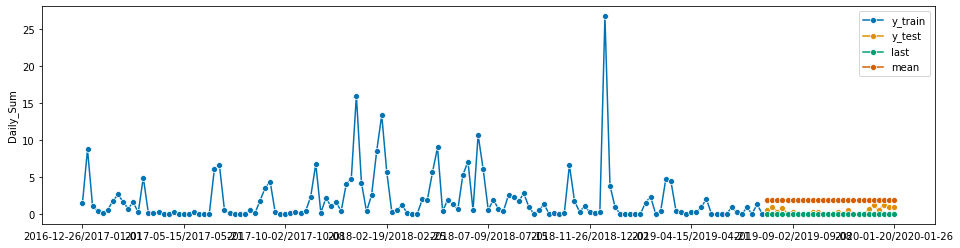

In [80]:
plot_series(y_train, y_test, y_last_preds, y_mean_preds,
            labels=['y_train', 'y_test', 'last', 'mean']);

/Users/melissamcmillan/opt/anaconda3/envs/timer/lib/python3.8/site-packages/pmdarima/utils/visualization.py:219: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  res = tsaplots.plot_acf(


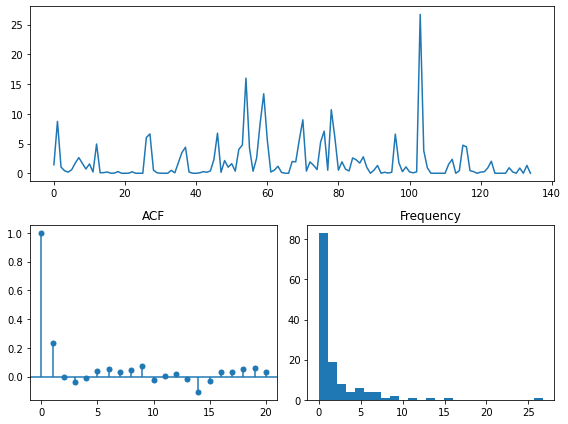

In [81]:
#I'm going to try an auto-arima model
tsdisplay(y_train, lag_max=20)

In [82]:
model = pmd.auto_arima(y_train, m=52, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.34 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=723.130, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=719.450, Time=0.59 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=718.952, Time=0.53 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=756.882, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=717.363, Time=0.02 sec
 ARIMA(0,0,1)(1,0,0)[52] intercept   : AIC=718.931, Time=0.56 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=inf, Time=2.72 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=719.347, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[52] intercept   : AIC=719.342, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=717.734, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[52] intercept   : AIC=721.305, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[52]             : AIC=738.721, Time=0.01 sec

Best model:  ARIMA(0,0,1)(0,0,0)[52] intercept
Total fit time: 9.061 seconds


In [83]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  135
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -355.681
Date:                Wed, 03 Mar 2021   AIC                            717.363
Time:                        13:39:08   BIC                            726.079
Sample:                             0   HQIC                           720.905
                                - 135                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.9042      0.678      2.807      0.005       0.574       3.234
ma.L1          0.2403      0.088      2.746      0.006       0.069       0.412
sigma2        11.3706      0.728     15.609      0.000       9.943      12.798
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3454.84
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               4.19   Skew:                             4.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
arima_preds = model.predict(y_test.shape[0])
arima_preds = pd.Series(arima_preds, y_test.index)
arima_preds

2019-07-29/2019-08-04    1.456475
2019-08-05/2019-08-11    1.904250
2019-08-12/2019-08-18    1.904250
2019-08-19/2019-08-25    1.904250
2019-08-26/2019-09-01    1.904250
2019-09-02/2019-09-08    1.904250
2019-09-09/2019-09-15    1.904250
2019-09-16/2019-09-22    1.904250
2019-09-23/2019-09-29    1.904250
2019-09-30/2019-10-06    1.904250
2019-10-07/2019-10-13    1.904250
2019-10-14/2019-10-20    1.904250
2019-10-21/2019-10-27    1.904250
2019-10-28/2019-11-03    1.904250
2019-11-04/2019-11-10    1.904250
2019-11-11/2019-11-17    1.904250
2019-11-18/2019-11-24    1.904250
2019-11-25/2019-12-01    1.904250
2019-12-02/2019-12-08    1.904250
2019-12-09/2019-12-15    1.904250
2019-12-16/2019-12-22    1.904250
2019-12-23/2019-12-29    1.904250
2019-12-30/2020-01-05    1.904250
2020-01-06/2020-01-12    1.904250
2020-01-13/2020-01-19    1.904250
2020-01-20/2020-01-26    1.904250
Freq: W-SUN, dtype: float64

In [85]:
#get the rmse for the sarimax model
np.round(mse(y_test, arima_preds, squared=False), decimals=2)

1.57

Now I'm going to try a sarimax model that takes in exogenous features. Since experimenting with the different features above, I decided to focus on the average volume of water/ft lateral that did so well before and see how it holds up with this catalog. In future work, I might test this catalog more, but with limited time I didn't do extensive modelling with this dataset.

In [86]:
sarimax_rate = pmd.auto_arima(y_train, X=train_subset[['avg_volh2o_per_ft']], m=52, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=728.202, Time=5.68 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=728.758, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=723.914, Time=0.82 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=724.170, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=727.102, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=722.074, Time=0.09 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=724.074, Time=1.04 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=726.074, Time=1.20 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=723.998, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=723.999, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=722.170, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=725.917, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[52]             : AIC=720.289, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[52]             : AIC=722.112, Time=2.44 sec
 ARIMA(1,0,0)(0,0,1)[52]         

In [87]:
sarimax_rate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  135
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -357.144
Date:                Wed, 03 Mar 2021   AIC                            720.288
Time:                        13:39:25   BIC                            729.004
Sample:                    01-01-2017   HQIC                           723.830
                         - 07-28-2019                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
avg_volh2o_per_ft     0.0008      0.000      2.538      0.011       0.000       0.001
ma.L1                 0.2720      0.081      3.372      0.001       0.114       0.430
sigma2               11.5208      0.660     17.446      0.000      10.226      12.815
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              3396.00
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               4.61   Skew:                             4.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [88]:
sarimax_rate_preds = sarimax_rate.predict(y_test.shape[0], test_subset[['avg_volh2o_per_ft']])

In [89]:
#get the rmse for the sarimax model
np.round(mse(y_test, sarimax_rate_preds, squared=False), decimals=2)

1.83

In summary of modelling the Fasola/TexNet catalog, I found that using the avg_volh2o_per_ft was the best exogenous feature, and using previous seismicity (or variations of the target) did well in forecasting.

#### Part 3: Modelling the Mega catalog/dataset

Now I'd like to experiment with modelling the data as far back as I can go. I'm going to load in the mega_df dataset and resample to Weekly. I'm also going to use Daily_Avg as my target, because from my EDA plots made in R (ggplot), that target seemed to be most telling. 

In [90]:
mega_df = pd.read_csv('oil_and_gas_data/data_for_modelling/mega_data_ready_for_modelling.csv', index_col=0)

In [91]:
#first thing to do is drop na values
mega_df = mega_df.dropna()
mega_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2863 entries, 2012-03-02 to 2020-12-05
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Daily_Sum          2863 non-null   float64
 1   Daily_Avg          2863 non-null   float64
 2   Daily_Count        2863 non-null   int64  
 3   Rig_Count          2863 non-null   float64
 4   WTI_Spot_Price     2863 non-null   float64
 5   Brent_Spot_Price   2863 non-null   float64
 6   fracs_per_day      2863 non-null   float64
 7   volume_per_day     2863 non-null   float64
 8   avg_volh2o_per_ft  2863 non-null   float64
 9   APIs               2863 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 246.0+ KB


So the date range I will model is 3-2-2012 to 1-31-2020 (I can do a more recent model, but I'm not ready to model the havoc that COVID caused to the industry). 

In [92]:
mega_df.index = pd.to_datetime(mega_df.index)
mega_df = mega_df.loc[:'1-31-2020',]
mega_df.tail()

,Daily_Sum,Daily_Avg,Daily_Count,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft,APIs
2020-01-27,0.0,0.0,0,33.0,53.09,58.54,45.0,4.278683e+07,1642.821249,"[42255361850000, 42255361860000, 4225536568000..."
2020-01-28,1.9,1.9,1,33.0,53.33,59.37,46.0,4.433917e+07,1658.283946,"[42255361850000, 42255361860000, 4225536568000..."
2020-01-29,0.0,0.0,0,33.0,53.29,59.46,44.0,4.293038e+07,1624.508496,"[42255361850000, 42255361860000, 4225536569000..."
2020-01-30,0.0,0.0,0,33.0,52.19,57.72,46.0,4.500210e+07,1624.812672,"[42255361850000, 42255361860000, 4225536559000..."
2020-01-31,0.0,0.0,0,33.0,51.58,57.77,46.0,4.500210e+07,1624.812672,"[42255361850000, 42255361860000, 4225536559000..."


In [93]:
#time to resample to Weekly averages
mega_df_weekly = mega_df.resample('W').mean()

In [94]:
mega_df_weekly.index = mega_df_weekly.index.to_period('W')

In [95]:
mega_df_weekly.dropna(inplace=True)

In [96]:
y = mega_df_weekly['Daily_Avg']
y

2012-02-27/2012-03-04    0.000000
2012-03-05/2012-03-11    0.000000
2012-03-19/2012-03-25    0.000000
2012-03-26/2012-04-01    0.000000
2012-05-28/2012-06-03    0.000000
                           ...   
2019-12-30/2020-01-05    0.571429
2020-01-06/2020-01-12    0.635714
2020-01-13/2020-01-19    0.607143
2020-01-20/2020-01-26    0.928571
2020-01-27/2020-02-02    0.380000
Freq: W-SUN, Name: Daily_Avg, Length: 386, dtype: float64

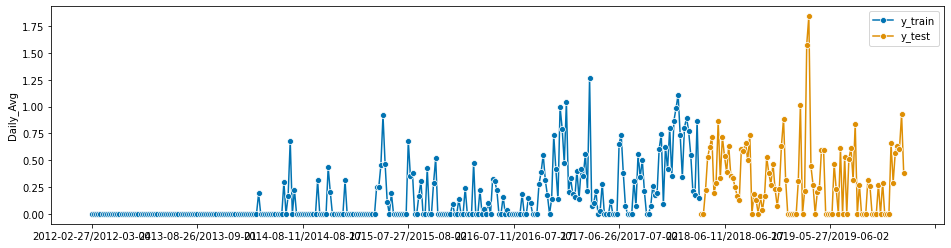

In [97]:
#going to do a train_test_split
y_train, y_test = temporal_train_test_split(y)
plot_series(y_train, y_test, labels=['y_train', 'y_test']);

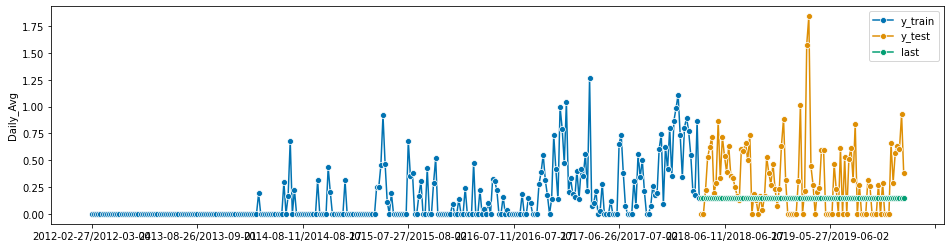

In [98]:
#time to make a baseline null model using the last value
naive_last = NaiveForecaster(strategy= 'last')
naive_last.fit(y_train)
y_last_preds = naive_last.predict(list(range(1,len(y_test)+1)))
plot_series(y_train, y_test, y_last_preds, labels=['y_train', 'y_test', 'last']);

In [99]:
np.round(mse(y_test, y_last_preds, squared=False), decimals=2)

0.38

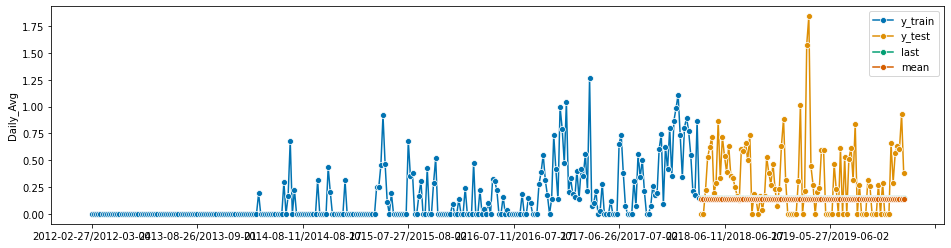

In [100]:
#time to make a baseline null model using the mean value
naive_mean = NaiveForecaster(strategy= 'mean')
naive_mean.fit(y_train)
y_mean_preds = naive_mean.predict(list(range(1,len(y_test)+1)))
plot_series(y_train, y_test, y_last_preds, y_mean_preds, 
            labels=['y_train', 'y_test', 'last', 'mean']);

In [101]:
np.round(mse(y_test, y_mean_preds, squared=False), decimals=2)

0.39

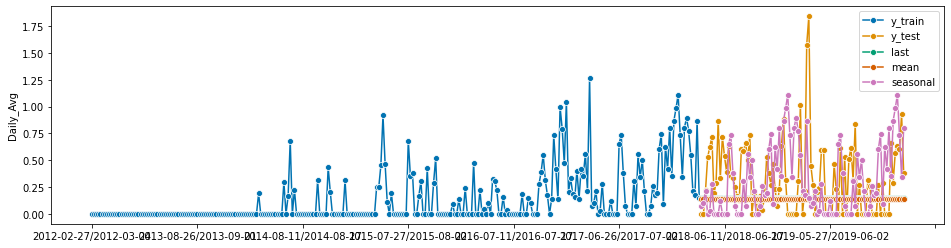

In [102]:
#that did very similar to the last null
#now I'm going to try a seasonal model and see how that does
naive_seasonal = NaiveForecaster(strategy= 'last', sp=52)
naive_seasonal.fit(y_train)

y_seasonal_preds = naive_seasonal.predict(list(range(1,len(y_test)+1)))

plot_series(y_train, y_test, y_last_preds, y_mean_preds, y_seasonal_preds,
            labels=['y_train', 'y_test', 'last', 'mean', 'seasonal']);

In [103]:
np.round(mse(y_test, y_seasonal_preds, squared=False), decimals=2)

0.46

In [104]:
#it didn't do as well as the null, but oh well!
#going to try a SARIMA/Auto-ARIMA model and see how that does
sarima1_mega = AutoARIMA(sp=52, suppress_warnings=True, trace=True)
sarima1_mega.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=7.02 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=-16.887, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=-68.766, Time=1.34 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=-109.276, Time=2.33 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=-18.885, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=-110.669, Time=0.06 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=-109.140, Time=1.74 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=5.87 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=-116.334, Time=0.15 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=-114.893, Time=3.81 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AIC=-115.040, Time=4.35 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=6.75 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=-70.602, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[52] intercept   : AIC=-119.215, Time=0.23 sec
 ARIMA(2,1,1)(1,0,0)[52] intercept   :

AutoARIMA(sp=52, suppress_warnings=True, trace=True)

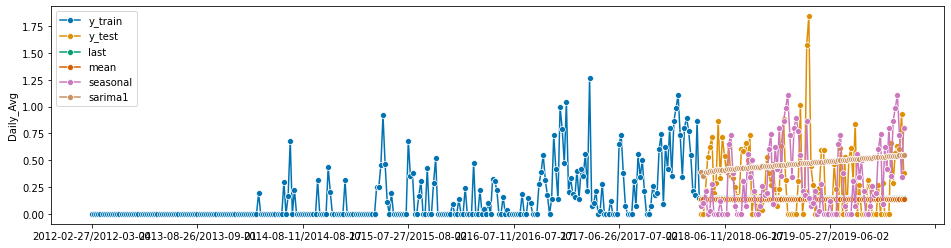

In [105]:
sarima1_preds = sarima1_mega.predict(list(range(1,len(y_test)+1)))
plot_series(y_train, y_test, y_last_preds, y_mean_preds, y_seasonal_preds, sarima1_preds,
            labels=['y_train', 'y_test', 'last', 'mean', 'seasonal', 'sarima1']);

In [106]:
np.round(mse(y_test, sarima1_preds, squared=False), decimals=2)

0.37

In [107]:
#hey! that one beat the null models! woot!!!

After experimenting with each of the exogenous features, I found (once again) that the average volume of water injected per foot of lateral performed best. Here is that model:

In [108]:
#now I'm going to try avg_vol_per_ft
#set up X and y; y will stay the same
X = mega_df_weekly[['avg_volh2o_per_ft']]
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)

In [109]:
sarima3_vol = pmd.auto_arima(y_train, X_train, m=52, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=-107.728, Time=3.10 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=-43.063, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=-91.322, Time=1.68 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=-83.279, Time=5.30 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=-39.851, Time=0.14 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=-110.730, Time=6.20 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=-112.742, Time=0.28 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=-99.621, Time=5.86 sec
 ARIMA(1,0,2)(0,0,0)[52] intercept   : AIC=-115.138, Time=0.40 sec
 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=-110.479, Time=6.83 sec
 ARIMA(1,0,2)(0,0,1)[52] intercept   : AIC=-113.095, Time=9.73 sec
 ARIMA(1,0,2)(1,0,1)[52] intercept   : AIC=-110.217, Time=6.49 sec
 ARIMA(0,0,2)(0,0,0)[52] intercept   : AIC=-94.415, Time=0.28 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=-116.301, Time=0.33 sec
 ARIMA(1,0,1)(1,0,0)[52] 

In [110]:
sarima3_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  289
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  63.166
Date:                Wed, 03 Mar 2021   AIC                           -118.333
Time:                        13:41:36   BIC                           -103.667
Sample:                    03-04-2012   HQIC                          -112.456
                         - 03-25-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
avg_volh2o_per_ft  9.617e-05   2.35e-05      4.095      0.000    5.01e-05       0.000
ar.L1                 0.8169      0.049     16.568      0.000       0.720       0.913
ma.L1                -0.4781      0.073     -6.590      0.000      -0.620      -0.336
sigma2                0.0386      0.002     17.111      0.000       0.034       0.043
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               360.76
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):              11.75   Skew:                             1.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [111]:
sarima3_vol_preds = sarima3_vol.predict(y_test.shape[0], X_test)
np.round(mse(y_test, sarima3_vol_preds, squared=False), decimals=2)

0.36

In [133]:
sarima3_vol_preds_series = pd.Series(sarima3_vol_preds, index=y_test.index)

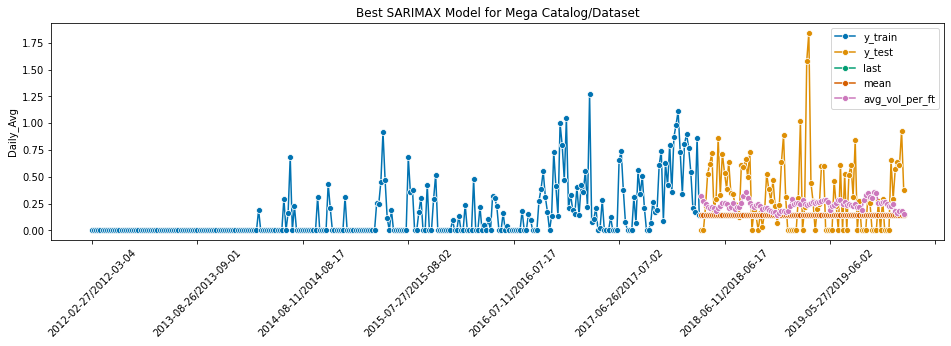

In [154]:
plot_series(y_train, y_test, y_last_preds, y_mean_preds, sarima3_vol_preds_series,
            labels=['y_train', 'y_test', 'last', 'mean', 'avg_vol_per_ft'])
plt.xticks(rotation=45)
plt.title('Best SARIMAX Model for Mega Catalog/Dataset');

In summary of the SARIMA modelling, I found that the models performed best when using the Mega catalog/dataset. It had the biggest time range, and I think that helped the model. Additionally, I found the target of Daily Average Magnitude to be the best in terms of the model performing as much as .02 rmse better than the null (I know it's not that much above the mean, but it's the best out of all of these models run between the three catalogs). Figuring out the best catalog, target, and exogenous features was very much an iterative process, and was very much driven by the EDA and plotting in my Rmd file. Again, for a more detailed walkthrough of my modelling, please see the equivalent notebook in my OLD folder.  